## Packages



In [1]:
library(tidyverse)
library(spacyr)
library(usmap)

data(state)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Starting a spacyr session



In [2]:
spacy_initialize(python_executable = "/srv/conda/envs/notebook/bin/python", model = "en_core_web_sm")

successfully initialized (spaCy Version: 3.4.2, language model: en_core_web_sm)

(python options: type = "python_executable", value = "/srv/conda/envs/notebook/bin/python")



## Getting the data



In [3]:
data <- read.csv("https://llc.herokuapp.com/summaries.csv?sql=select%0D%0A++rowid%2C%0D%0A++content_text%0D%0Afrom%0D%0A++files%0D%0Awhere%0D%0A++%22path%22+like+%2274_2_s%25%22%0D%0Aorder+by%0D%0A++path&_size=max")

## create a single text



In [4]:
text <- data$content_text %>% str_c()

## Entity extraction



In [5]:
parsed_text <- spacy_parse(text, lemma = TRUE, entity = TRUE, nounphrase = TRUE)
entities <- entity_extract(parsed_text)

## Geopolitical Entities



In [6]:
gpes <- entities %>%
  filter(entity_type == "GPE") %>% 
  mutate(across('entity', str_replace_all, '_', ' ')) %>% 
  filter(str_detect(entity, "States", negate = TRUE)) %>% 
  filter(str_detect(entity, "District", negate = TRUE)) %>% 
  filter(str_detect(entity, "County", negate = TRUE)) %>% 
  filter(str_detect(entity, "City", negate = TRUE)) %>% 
  filter(str_detect(entity, "\\d+", negate = TRUE)) %>% 
  filter(str_detect(entity, "^the", negate = TRUE)) %>% 
  filter(str_detect(entity, "^(?!Rhode) Island", negate = TRUE)) %>% 
  filter(str_detect(entity, "^U\\.", negate = TRUE))

## State Names



In [7]:
state_names <- tibble(entity = state.name)

## Abbreviated states



In [8]:
states_abbrev <- gpes %>%
  filter(str_detect(entity, "\\.$"))

## Recoding Abbreviations



In [9]:
distinct_states_abbrev <- sort(unique(states_abbrev$entity))

distinct_states_abbrev

[1] "Ala."   "Ark."   "Colo."  "Conn."  "D. C."  "Fla."   "Ga."    "Ind."  
 [9] "Ky."    "Mass."  "Md."    "Mich."  "Mont."  "Okla."  "Tenn."  "Tex ." 
[17] "Va."    "Vt ."   "W. Va." "Wis."

## Recoding Vector



In [10]:
expanded_states_abbrev <- c(
  "Ala." = "Alabama",
  "Ark." = "Arkansas",
  "Colo." = "Colorado",
  "Conn." = "Connecticut",
  "Fla." = "Florida",
  "Ga." = "Georgia",
  "Ind." = "Indiana",
  "Ky." = "Kentucky",
  "Mass." = "Massachusetts",
  "Md." = "Maryland",
  "Mich." = "Michigan",
  "Mont." = "Montana",
  "Okla." = "Oklahoma",
  "Tenn." = "Tennessee",
  "Tex ." = "Texas",
  "Va." = "Virginia",
  "Vt ." = "Vermont",
  "W. Va." = "West Virginia",
  "Wis." = "Wisconsin"
)

## Finally recoding



In [11]:
states <- gpes %>% 
  mutate(entity = recode_factor(entity, !!!expanded_states_abbrev)) %>% 
  inner_join(state_names) %>% 
  select(entity)

Joining, by = "entity"



## State counts



In [12]:
state_counts <- states %>% 
  count(entity) %>% 
  right_join(state_names) %>% 
  mutate(full = entity) %>% 
  select(full, n)

Joining, by = "entity"



## Mapping



### Map Data



In [13]:
state_map_data <- us_map(regions = c("state"))

### Joining map data



In [20]:
map_df <- state_counts %>% 
  inner_join(state_map_data) %>% 
  select(state = full, n) %>% 
  distinct()

map_df

Joining, by = "full"



state,n
<chr>,<int>
Alabama,5
Alaska,9
Arizona,4
Arkansas,6
California,7
Colorado,3
Connecticut,2
Delaware,2
Florida,5


### Plotting



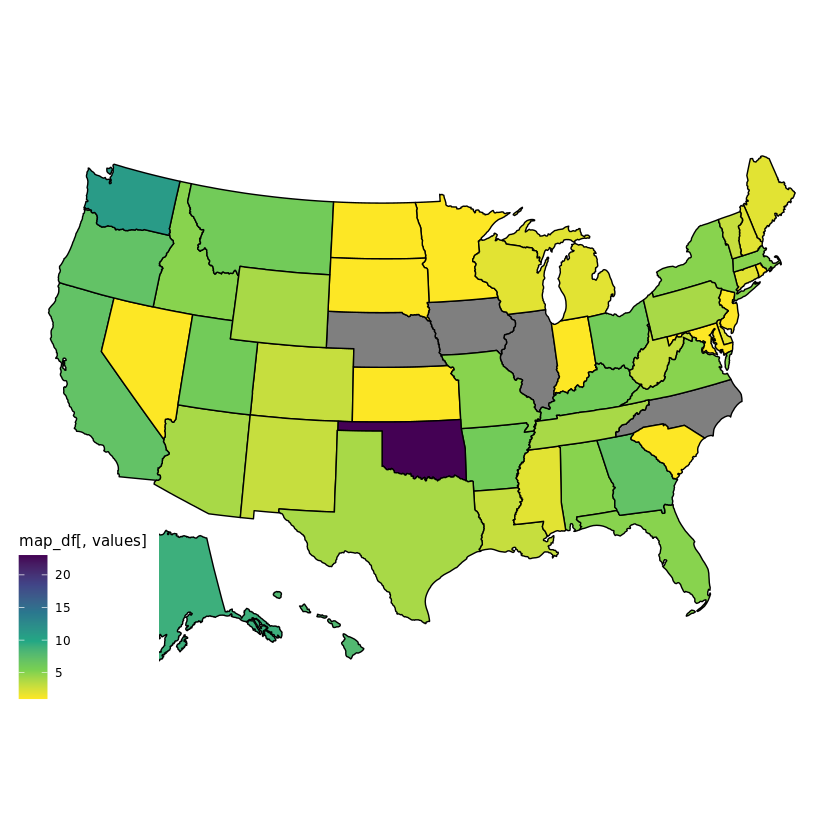

In [21]:
plot_usmap(data = map_df, values = c("n")) +
  scale_fill_viridis_c(direction = -1)